# Задание - Предсказание уровня экспресси белка

<div class="alert alert-info">
<b>Про биологию</b>
    
Экспрессия — процесс, в ходе которого наследственная информация от гена (последовательности нуклеотидов ДНК) преобразуется в функциональный продукт — белок. Уровнем экспрессии называют - количество белка, производящегося в этом процессе. Чем выше экспрессия белка, тем большее количество этого белка появляется в клетках человека. 
    
    

<div class="alert alert-info">    
<b>Важность задачи</b>
    
Существует множество причин необходимости в знании уровня экспресии белка. Например - это позволяет ученым разрабатывать лекарственные средства и оптимизировать их разработку. Теперь вам предстоит побыть в роли биоинформатика и помочь науке!
    
</div>


<div class="alert alert-info">
<b>Про Датасет</b>
    
Датасет представляет собой граф взаимойдествия белков. Где узлы это белки, взаимодействие между белками это ребро. 

Для каждого белка известен уровень его экспрессии. Ниже приведен список ребер `edges`. Информация по экспрессии белков, разбитая на `train` и `test`.
   
    
</div>

<div class="alert alert-info">
<b>Про Задачу</b>
    
Вам предлагается предсказать экспрессию белков (`target`) по приведенным данным для отложенной выборки. Ответы в отложенной выборке `test` даны вам для самостоятельной валидации.


    
   
    

<div class="alert alert-info">
<b>Замечание и комментарии</b>
    
    

По ряду причин датасет был упрощен так, чтобы выполнялись следующие условия:
* у графа одна компонента связанности. 
* удалены слишком крупные хабы
* плотность связей графа уменьшена
* решить задачу можно классическими ML подходами
    
   

<div class="alert alert-info">
<b>Оценка результатов</b>
    


Оценка точности модели будет оцениваться по метрике MSE на отложенной выборке `test`
        
</div>

<div class="alert alert-info">
<b>Автор задачи</b>

По всем дополнительным вопросами писать Александру Миленькину
* Телеграмм: Alerin75infskin
* Почта: milenkin.aa@phystech.edu
        
</div>

In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

## 1 EDA

### 1.1 Общая информация

Загрузка данных

In [2]:
#Список ребер графа 
try:
    edges = pd.read_csv("edges.csv", sep=",") # Подгрузим данные
except:
    edges = pd.read_csv("https://raw.githubusercontent.com/a-milenkin/Otus_HW_protein_expression/main/edges.csv", sep=",") # Подгрузим данные

edges.head()

,node_1,node_2
0,344,50
1,344,153
2,344,532
3,344,679
4,344,986


In [3]:
#Подгрузим тренирочную выборку
try:
    train = pd.read_csv("train.csv", sep=",") # Подгрузим данные
except:
    train = pd.read_csv("https://raw.githubusercontent.com/a-milenkin/Otus_HW_protein_expression/main/train.csv", sep=",") # Подгрузим данные

train.head()

,target,node
0,0.251968,11142
1,0.689541,2243
2,0.678245,15514
3,0.272500,20944
4,0.248888,8721


In [4]:
#Подгрузим отложенную выборку для валидации
try:
    test = pd.read_csv("test.csv", sep=",")
except:
    test = pd.read_csv("https://raw.githubusercontent.com/a-milenkin/Otus_HW_protein_expression/main/test.csv", sep=",")

test.head()

,target,node
0,0.279231,817
1,0.380795,9574
2,0.686527,1607
3,0.303594,4782
4,0.367374,24125


Изучим содержимое датасетов

In [5]:
edges.head()

,node_1,node_2
0,344,50
1,344,153
2,344,532
3,344,679
4,344,986


In [6]:
edges.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594174 entries, 0 to 594173
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   node_1  594174 non-null  int64
 1   node_2  594174 non-null  int64
dtypes: int64(2)
memory usage: 9.1 MB


In [7]:
train.head()

,target,node
0,0.251968,11142
1,0.689541,2243
2,0.678245,15514
3,0.272500,20944
4,0.248888,8721


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   target  8000 non-null   float64
 1   node    8000 non-null   int64  
dtypes: float64(1), int64(1)
memory usage: 125.1 KB


In [9]:
train.describe()

,target,node
count,8000.000000,8000.000000
mean,0.531021,13278.330125
std,0.673008,8750.366724
min,0.162075,0.000000
25%,0.263916,5207.750000
50%,0.339945,12825.500000
75%,0.521007,20751.250000
max,12.216818,31204.000000


In [10]:
test.head()

,target,node
0,0.279231,817
1,0.380795,9574
2,0.686527,1607
3,0.303594,4782
4,0.367374,24125


In [11]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   target  2000 non-null   float64
 1   node    2000 non-null   int64  
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


In [12]:
test.describe()

,target,node
count,2000.000000,2000.0000
mean,0.569324,13103.7940
std,0.867445,8726.0327
min,0.163269,8.0000
25%,0.266700,5314.7500
50%,0.341745,12341.0000
75%,0.529549,20662.5000
max,15.098584,31120.0000


Номера узлов идут не подряд. Проверим, одинаковые ли узлы содержатся в графе и датасетах.

### 1.2 Проверка на соответствие узлов

In [13]:
edges.nunique()

node_1    9889
node_2    9862
dtype: int64

Список уникальных узлов в датасете с ребрами

In [14]:
edges_uniq = pd.concat([edges['node_1'], edges['node_2']], axis=0).unique()
edges_uniq.sort()
edges_uniq

array([    0,     1,     2, ..., 31179, 31193, 31204], dtype=int64)

Список уникальных узлов в датасетах с таргетом

In [15]:
sample_uniq = pd.concat([train['node'], test['node']]).unique()
sample_uniq.sort()
sample_uniq

array([    0,     1,     2, ..., 31179, 31193, 31204], dtype=int64)

In [16]:
np.mean(edges_uniq == sample_uniq)

1.0

Граф и выборки содержат одни и те же узлы.

### 1.3 Распределение целевого признака

Распределения целевого признака в обучающей и тестовой выборках

<Axes: >

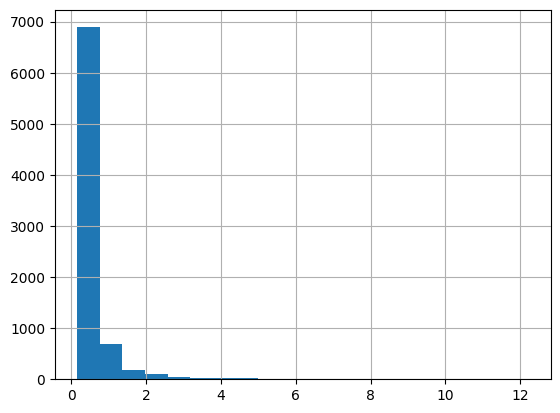

In [17]:
train['target'].hist(bins=20)

<Axes: >

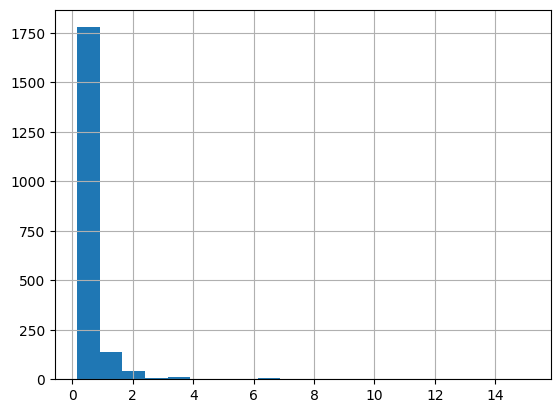

In [18]:
test['target'].hist(bins=20)

### 1.4 Формирование графа

In [19]:
G = nx.Graph()

In [20]:
G.add_edges_from(edges.values)

In [21]:
print(G)

Graph with 10000 nodes and 594174 edges


## 2 Кластеризация

Идея решения задачи:
1. Выделить в графе кластеры
2. Найти характерные значения тагрета для каждого кластера (среднее) по обучающей выборке
3. По принадлежности узлов из тестовой выборки полученным кластерам присвоить им характерные значения кластеров

### 2.1 louvain_communities

In [22]:
clust = nx.community.louvain_communities(G, seed=123)

In [23]:
len(clust)

4

Функция для расчета характерных значений кластеров

In [24]:
def culc_clust_mean(clust, train):
    clust_nodes = {}
    clust_means = {}
    clust_std = {}
    for i, cl in enumerate(clust):
        clust_nodes[f'c_{i}'] = cl
        clust_means[f'c_{i}'] = train[train['node'].isin(cl)]['target'].mean()
        clust_std[f'c_{i}'] = train[train['node'].isin(cl)]['target'].std()
    return clust_nodes, clust_means, clust_std

In [25]:
clust_nodes, clust_means, clust_std = culc_clust_mean(clust, train)

In [26]:
clust_means

{'c_0': 0.5644268623487775,
 'c_1': 0.5270000652629033,
 'c_2': 0.524043772223107,
 'c_3': 0.4969115324108884}

In [27]:
clust_std

{'c_0': 0.5868964184760762,
 'c_1': 0.7293429218779384,
 'c_2': 0.8141986077431075,
 'c_3': 0.45377061595682755}

Стандартное отклонение таргетов узлов внутри кластеров имеет порядок их средних значений. Кластеры не отражают группы белков с похожими значениями таргета.

Функция для назначения тагрета по принадлежности узла определенному кластеру

In [28]:
def predict(test_nodes, clust_nodes, clust_means):
    pred = pd.DataFrame()
    pred['node'] = test_nodes
    for cl in clust_nodes.keys():
        pred.loc[pred[pred['node'].isin(clust_nodes[cl])].index,'target'] = clust_means[cl]
    return pred

In [29]:
pred = predict(test['node'], clust_nodes, clust_means)

Рассчитаем ошибку

In [30]:
mse = pd.DataFrame(columns=['MSE'])

In [31]:
mse.loc['louvain_communities', 'MSE'] = mean_squared_error(test['target'], pred['target'])

In [32]:
mse

,MSE
louvain_communities,0.753989


### 2.2 louvain_communities 2

Протестируем алгоритм с разбиением на более мелкие кластеры

In [33]:
clust1 = nx.community.louvain_communities(G, seed=123, resolution=2)

In [34]:
len(clust1)

31

Рассчитаем характерные значения кластеров

In [35]:
clust_nodes1, clust_means1, clust_std1 = culc_clust_mean(clust1, train)

Рассчитаем прогноз и ошибку на тестовой выборке

In [36]:
pred1 = predict(test['node'], clust_nodes1, clust_means1)

In [37]:
mse.loc['louvain_communities 2', 'MSE'] = mean_squared_error(test['target'], pred1['target'])

In [38]:
mse

,MSE
louvain_communities,0.753989
louvain_communities 2,0.789552


## 3 Обучение на сгенерированных признаках

Идея решения задачи:
1. На основе всех соседей рассчитать характерные значения для каждого узла из обучающей и тестовой выборок (основные статистики по значениям таргета обучающих узлов)
2. На обучающих узлах обучить регрессионную модель (признаки - рассчитанные статистики)
3. Сформировать прогноз для тестовых узлов по рассчитанным признакам

### 3.1 Генерация признаков

Датафрейм со всеми узлами

In [39]:
df = pd.DataFrame(index=pd.concat([train['node'], test['node']]))

Количество ребер у каждого узла

In [40]:
df['degree'] = pd.Series(dict(G.degree()))

In [41]:
df.sort_values(by='degree')

,degree
node,
8286,16
18678,19
15257,21
27726,21
25140,22
...,...
87,2192
251,2231
675,2278


Статистики по соседним вершинам: 
1. Среднее значение таргета узлов из обучающей выборки
2. Минимальное
3. Максимальное
4. Стандартное отклонение

In [42]:
[n for n in G.neighbors(8286)]

[20535,
 6888,
 18910,
 11909,
 22581,
 1490,
 4650,
 6054,
 8166,
 14029,
 14432,
 14968,
 16457,
 20822,
 21019,
 25468]

In [43]:
for node in df.index:
    neighbors = [n for n in G.neighbors(node)]
    df.loc[node, 'mean'] = train[train['node'].isin(neighbors)]['target'].mean()
    df.loc[node, 'min'] = train[train['node'].isin(neighbors)]['target'].min()
    df.loc[node, 'max'] = train[train['node'].isin(neighbors)]['target'].max()
    df.loc[node, 'std'] = train[train['node'].isin(neighbors)]['target'].std()

In [44]:
df

,degree,mean,min,max,std
node,,,,,
11142,50,4.017762,0.305744,12.216818,3.541939
2243,190,2.532769,0.239880,12.216818,2.557981
15514,172,1.434059,0.174303,12.216818,2.163409
20944,61,1.821072,0.187413,8.247335,1.902601
8721,62,1.592254,0.165393,7.283009,1.888476
...,...,...,...,...,...
1849,59,1.963039,0.191304,7.283009,1.997734
16977,48,1.830048,0.215474,10.417358,2.142104
5952,48,0.650097,0.213872,2.827763,0.494535


Сформируем выборки

In [45]:
X_train = df.loc[train['node'], ['degree', 'mean', 'min', 'max', 'std']]

In [46]:
X_train

,degree,mean,min,max,std
node,,,,,
11142,50,4.017762,0.305744,12.216818,3.541939
2243,190,2.532769,0.239880,12.216818,2.557981
15514,172,1.434059,0.174303,12.216818,2.163409
20944,61,1.821072,0.187413,8.247335,1.902601
8721,62,1.592254,0.165393,7.283009,1.888476
...,...,...,...,...,...
19479,76,2.091388,0.229834,10.641986,2.225693
2182,82,3.147782,0.268787,12.216818,2.935501
20535,60,1.127279,0.189695,8.554136,1.416116


In [47]:
Y_train = train.set_index('node', drop=True)

In [48]:
Y_train

,target
node,
11142,0.251968
2243,0.689541
15514,0.678245
20944,0.272500
8721,0.248888
...,...
19479,0.329241
2182,0.350863
20535,0.288309


In [49]:
X_test = df.loc[test['node'], ['degree', 'mean', 'min', 'max', 'std']]

In [50]:
Y_test = test.set_index('node', drop=True)

In [51]:
X_test

,degree,mean,min,max,std
node,,,,,
817,70,1.116375,0.202044,9.493607,1.376835
9574,92,2.419952,0.164362,9.579662,2.304885
1607,176,1.054218,0.176018,6.295359,0.955886
4782,83,2.592675,0.186125,12.216818,2.506169
24125,79,1.366712,0.179088,7.283009,1.706989
...,...,...,...,...,...
1849,59,1.963039,0.191304,7.283009,1.997734
16977,48,1.830048,0.215474,10.417358,2.142104
5952,48,0.650097,0.213872,2.827763,0.494535


In [52]:
Y_test

,target
node,
817,0.279231
9574,0.380795
1607,0.686527
4782,0.303594
24125,0.367374
...,...
1849,0.327932
16977,0.278870
5952,0.233343


Корреляционный анализ

In [53]:
pd.concat([X_train, Y_train], axis=1).corr()

,degree,mean,min,max,std,target
degree,1.000000,-0.232675,-0.275017,0.110943,-0.226000,0.988026
mean,-0.232675,1.000000,0.510396,0.657388,0.905177,-0.263593
min,-0.275017,0.510396,1.000000,0.182977,0.379673,-0.286934
max,0.110943,0.657388,0.182977,1.000000,0.829164,0.079750
std,-0.226000,0.905177,0.379673,0.829164,1.000000,-0.248756
target,0.988026,-0.263593,-0.286934,0.079750,-0.248756,1.000000


<Axes: >

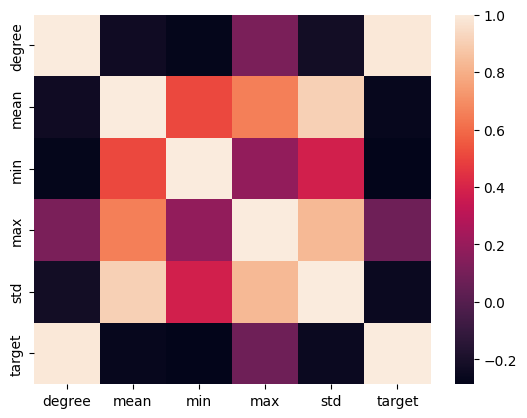

In [54]:
sns.heatmap(pd.concat([X_train, Y_train], axis=1).corr())

Есть столбцы с высокой линейной связью. Между таргетом и столбцом `degree` есть очень высокая связь. В этом случае эффективно применение линейной регрессии.

Масштабирование

In [55]:
scaler = StandardScaler()

In [56]:
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns)

In [57]:
X_train_scaled

,degree,mean,min,max,std
node,,,,,
11142,-0.446330,2.808835,2.855918,1.066091,2.161398
2243,0.485578,1.039950,0.980189,1.066091,0.920927
15514,0.365761,-0.268805,-0.887358,1.066091,0.423493
20944,-0.373108,0.192195,-0.513995,-0.249388,0.094693
8721,-0.366452,-0.080367,-1.141107,-0.568963,0.076886
...,...,...,...,...,...
19479,-0.273261,0.514189,0.694087,0.544195,0.502014
2182,-0.233322,1.772537,1.803425,1.066091,1.396864
20535,-0.379765,-0.634233,-0.449029,-0.147715,-0.518617


In [58]:
X_test_scaled = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

In [59]:
X_test_scaled

,degree,mean,min,max,std
node,,,,,
817,-0.313200,-0.647221,-0.097334,0.163624,-0.568137
9574,-0.166757,0.905565,-1.170461,0.192143,0.601851
1607,0.392387,-0.721261,-0.838529,-0.896269,-1.098826
4782,-0.226666,1.111308,-0.550680,1.066091,0.855609
24125,-0.253292,-0.349027,-0.751100,-0.568963,-0.151914
...,...,...,...,...,...
1849,-0.386421,0.361302,-0.403208,-0.568963,0.214627
16977,-0.459642,0.202887,0.285148,0.469754,0.396633
5952,-0.459642,-1.202640,0.239509,-2.045423,-1.680449


### 3.2 LinearRegression

In [60]:
linreg = LinearRegression()

In [61]:
linreg.fit(X_train_scaled, Y_train)

LinearRegression()

In [62]:
pred2 = linreg.predict(X_test_scaled)

In [63]:
pred2

array([[0.30887307],
       [0.39561942],
       [0.79234093],
       ...,
       [0.25849003],
       [1.04401747],
       [0.27788732]])

In [64]:
mse.loc['LinearRegression', 'MSE'] = mean_squared_error(Y_test, pred2)

In [65]:
mse

,MSE
louvain_communities,0.753989
louvain_communities 2,0.789552
LinearRegression,0.015265


### 3.3 Ridge

В данных есть мультиколлинеарность, применим L2-регуляризацию

In [66]:
ridge = Ridge(alpha=1.0)

In [67]:
ridge.fit(X_train_scaled, Y_train)

Ridge()

In [68]:
pred3 = ridge.predict(X_test_scaled)

In [69]:
pred3

array([[0.30908905],
       [0.39568175],
       [0.79241397],
       ...,
       [0.25852136],
       [1.04398738],
       [0.2779077 ]])

In [70]:
mse.loc['Ridge', 'MSE'] = mean_squared_error(Y_test, pred3)

In [71]:
mse

,MSE
louvain_communities,0.753989
louvain_communities 2,0.789552
LinearRegression,0.015265
Ridge,0.015277


### 3.4 RandomForestRegressor

Для поиска оптимальных параметров случайного леа воспользуемся поиском параметров по сетке

In [72]:
random_forest = RandomForestRegressor(random_state=123)

In [73]:
grid_space={'max_depth':[3,5,10],
            'n_estimators':[50,100,200],
           }

In [74]:
grid = GridSearchCV(random_forest,
                    param_grid=grid_space,
                    cv=4,
                    scoring='neg_root_mean_squared_error')

In [75]:
model_grid = grid.fit(X_train_scaled,Y_train)

c:\Users\Demina.LV\Documents\Scripts\OTUS\.venv\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Demina.LV\Documents\Scripts\OTUS\.venv\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


c:\Users\Demina.LV\Documents\Scripts\OTUS\.venv\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Demina.LV\Documents\Scripts\OTUS\.venv\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Demina.LV\Documents\Scripts\OTUS\.venv\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Demina.LV\Documents\Scripts\OTUS\.venv\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector 

In [76]:
pred4 = model_grid.predict(X_test_scaled)

In [77]:
pred4

array([0.34087398, 0.381445  , 0.76627594, ..., 0.27055136, 0.91210659,
       0.28424238])

In [78]:
mse.loc['RandomForest', 'MSE'] = mean_squared_error(Y_test, pred4)

In [79]:
mse

,MSE
louvain_communities,0.753989
louvain_communities 2,0.789552
LinearRegression,0.015265
Ridge,0.015277
RandomForest,0.014828


Параметры наилучшей модели

In [80]:
model_grid.best_params_

{'max_depth': 10, 'n_estimators': 100}

## 4 Выводы

Предсказывалась экспрессия белков по графу их взаимойдествия друг с другом. Был проведен анализ данных и построены распределния целевого признака. Для решения задачи было рассмотрено два пайплайна: на основе кластеризации графа и на основе генерации признаков.

На основе кластеризации графа:
1. Выделить в графе кластеры
2. Найти характерные значения тагрета для каждого кластера (среднее) по обучающей выборке
3. По принадлежности узлов из тестовой выборки полученным кластерам присвоить им характерные значения кластеров

Для кластеризации графа был протестирован алгоритм louvain_communities с кластеризацией на крупные кластеры (louvain_communities) и на более мелкие кластеры (louvain_communities 2).

На основе генерации признаков:
1. На основе всех соседей рассчитать характерные значения для каждого узла из обучающей и тестовой выборок (основные статистики по значениям таргета обучающих узлов)
2. Провести корреляционный анализ полученных признаков
3. На обучающих узлах обучить регрессионную модель (признаки - рассчитанные статистики)
4. Сформировать прогноз для тестовых узлов по рассчитанным признакам

По корреляционному анализу было установлено, что между таргетом и столбцом `degree` есть очень высокая связь. 

На сгенерированных признаках было протестировано 3 алгоритма:
1. LinearRegression
2. Ridge
3. RandomForest с автоподбором параметров

MSE рассмотренных алгоритмов:

In [82]:
mse

,MSE
louvain_communities,0.753989
louvain_communities 2,0.789552
LinearRegression,0.015265
Ridge,0.015277
RandomForest,0.014828


Наилучшее качество дает случайный лес с параметрами: 

In [83]:
model_grid.best_params_

{'max_depth': 10, 'n_estimators': 100}